# 多类别分类和神经网络
在本练习中，你将实现一对多逻辑回归和使用神经网络来识别手写数字。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io # 用来载入 OCTAVE *.mat 文件
import matplotlib.cm as cm # 用于在特定颜色映射中显示图像
import random # 为了随机选择图片显示
from scipy.special import expit # 向量化的sigmod函数
from PIL import Image # 用于图片处理

## 1. 多类别分类
在本练习中，你将使用逻辑回归和神经网络来识别手写数字（从0到9）。   
如今，自动手写数字识别被广泛使用 - 从识别邮件信封上的邮政编码（邮政编码）到识别银行支票上的金额。  
本练习将向你展示你学习的方法如何用于此分类任务。 在练习的第一部分中，你将扩展先前的逻辑回归实现并将其应用于一对一分类
### 1.1 数据集
* 你将在ex3data1.mat中获得一个数据集，其中包含5000个手写数字的训练示例。  
  .mat格式表示数据已保存为原生Octave / MATLAB矩阵格式，而不是像文本（ASCII）格式一样一个csv文件。  
 可以使用load命令将这些矩阵直接读入程序。加载后，正确尺寸和值的矩阵将出现在程序的内存中。矩阵已经命名，因此无需为其指定名称。  
* ex3data1.mat中有5000个训练示例，其中每个训练示例是数字的20像素乘20像素灰度图像。   
  每个像素由浮点数表示，该浮点数表示该位置处的灰度强度。 20×20像素网格被“展开”成400维向量。   
  这些训练样例中的每一个在我们的数据矩阵X中变成单行。这给出了5000乘400矩阵X，其中每行是手写数字图像的训练示例。  
  $$ X = 
  \begin{bmatrix} 
  -\ (x^{(1)})^T\ -\\
  -\ (x^{(2)})^T\ -\\
  ...\\
  -\ (x^{(m)})^T\ - 
  \end{bmatrix} \quad $$
* 训练集的第二部分是5000维向量y，包含训练集的标签。 为了兼容Octave / MATLAB索引，没有零索引。   
  因此，手写数字“0”标记为“10”，而数字“1”到“9”按其自然顺序标记为“1”到“9”。

In [2]:
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1) # 照常给矩阵X插入一列“1”
print ("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" %(X.shape,X[0].shape))
#X 是 5000 个图片. 每个图片是一行. 每个图片有400像素(20x20)
#y 是每个图片的类别. 1-10, 10代表手写数字“0”

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


### 1.2 数据可视化
从.mat文件导入的数据范围在0~1左右，最大值为1.12，最小值为-0.13。  
原作者使用的是scipy.misc.toimage()在新版中已经不可用，改用了PIL.Image.fromarray()。  
而PIL支持的8位灰度图像要求0~255，所以将数据乘以255才可以正常显示出图像

In [39]:
def getDatumImg(row):
    """
    从X矩阵获取1x400的一行数组，转化成20x20的图片数组并返回
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X矩阵随机获取100行，从每行创建出一个20x20的图片，然后把它们拼接成10x10网格的图像并显示
    """
    width, height = 20, 20 # 每个小图片的宽，高
    nrows, ncols = 10, 10  # 小图片行数列数
    show_y = False # 是否显示y的值
    
    # 如果没有指定要显示的图像，就随机从X矩阵中选择 nrows*ncols 个图像进行显示
    if not indices_to_display: 
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)  # indices_to_display 是随机从X矩阵中选择的行数
        show_y = True
         
    big_picture = np.zeros((height*nrows,width*ncols))
    pic_y=np.zeros((nrows,ncols))
    
    # 对于每一行，插入10个小图，然后切换到下一行，直到完成第10行
    irow, icol = 0, 0 # 正在添加的小图片的行数和列数
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[ irow*height: irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        pic_y[irow,icol]=0 if y[idx]==10 else y[idx]
        icol += 1
        
    big_picture *= 255     # Imag.fromarray不适用原数据，无法显示，转化一下
    img = Image.fromarray(big_picture)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap="gray")
    
    if show_y:
        print(pic_y)

[[5. 5. 4. 8. 5. 5. 5. 5. 2. 4.]
 [8. 2. 4. 9. 3. 1. 3. 2. 9. 7.]
 [2. 5. 8. 3. 2. 3. 6. 9. 2. 9.]
 [7. 6. 9. 7. 4. 1. 9. 4. 4. 0.]
 [1. 5. 3. 0. 0. 6. 0. 1. 5. 5.]
 [7. 0. 1. 3. 2. 8. 1. 3. 2. 5.]
 [6. 6. 7. 4. 9. 7. 2. 8. 8. 1.]
 [9. 0. 8. 9. 2. 9. 5. 2. 8. 0.]
 [2. 0. 4. 3. 9. 7. 3. 0. 7. 5.]
 [4. 5. 3. 4. 7. 0. 6. 5. 6. 7.]]


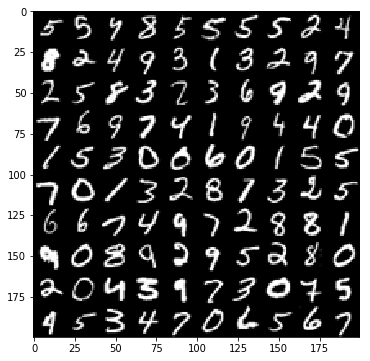

In [29]:
displayData()

### 1.3 向量化的逻辑回归
你将使用多个一对多逻辑回归模型来构建多类分类器。  
由于有10个类，所以需要训练10个单独的逻辑回归分类器。为了使这种培训更有效，确保代码很好地进行矢量化非常重要。  
在本节中，将实现逻辑回归的矢量化版本，该版本不使用任何for循环。
#### 1.3.1 向量化的代价函数
我们将从编写代价函数的矢量化版本开始。回想一下，在（非正则化）逻辑回归中，代价函数是:
$$J（θ）= \frac{1}{m}\sum\limits_{i=1}^n\big[ -y^{(i)}log(h_θ(x^{(i)}))- (1 - y^{(i)})log( 1 - h_θ(x^{(i)}))\big]$$
为了计算求和中的每个元素，我们必须计算每个例子i的 $h_θ(x^{(i)})$，其中 $h_θ(x^{(i)})= g(θ^Tx^{(i)})$ 且 $g(z)=\frac{1}{1 + e^{-z}}$ 是个sigmoid函数。事实证明，我们可以通过使用矩阵乘法快速计算所有示例。让我们将X和θ定义为  
$$X = 
\begin{bmatrix} 
-\ (x^{(1)})^T\ -\\
-\ (x^{(2)})^T\ -\\
...\\
-\ (x^{(m)})^T\ - 
\end{bmatrix} 
\quad 和 \quad
θ = 
\begin{bmatrix} 
θ_0 \\
θ_1\\
...\\
θ_m 
\end{bmatrix}$$  

然后，通过计算矩阵乘积Xθ，我们得到
$$ Xθ = 
\begin{bmatrix} 
-\ (x^{(1)})^Tθ\  -\\
-\ (x^{(2)})^Tθ\  -\\
...\\
-\  (x^{(m)})^Tθ\  - 
\end{bmatrix} =
\begin{bmatrix} 
-\  θ^T(x^{(1)})\  -\\
-\  θ^T(x^{(2)})\  -\\
...\\
-\  θ^T(x^{(m)})\  - 
\end{bmatrix}$$
在最后的等式中，我们使用了如果a和b是向量，则 $a^Tb = b^Ta$ 的事实。这允许我们在一行代码中计算所有示例i的乘积 $θ^Tx^{(i)}$。  
你的工作是编写未经正则化的代价函数。你的实现应使用我们上面提出的策略来计算 $θ^Tx^{(i)}$。你还应该使用矢量化方法来完成剩余的代价函数。  
代价函数完全矢量化版本不应包含任何循环。 （提示：您可能希望在编写此函数时使用逐元素乘法运算（.*）和求和运算和）

In [30]:
# 假设函数
def h(mytheta,myX):
    return expit(np.dot(myX,mytheta))

# 不带正则化的向量化的代价函数
def computeCost(mytheta,myX,myy):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    return (term1 - term2) / m #shape: (5000,5000)

#### 1.3.2 向量化的梯度
回想一下，（未正则化的）逻辑回归代价的梯度是一个向量，其中 $j^{th}$ 被定义为
$$\frac{∂J}{∂θ_j}= \frac{1}{m}\sum\limits_{i=1}^m\big((h_θ(x^{(i)}) - y^{(i)})x_j^{(i)}\big)$$ 
为了对数据集上的这个操作进行矢量化，我们首先明确地为所有 $θ_j$ 写出所有偏导数:
$$\begin{bmatrix} 
\frac{∂J}{∂θ_0}\\
\frac{∂J}{∂θ_1}\\
\frac{∂J}{∂θ_2}\\
...\\
\frac{∂J}{∂θ_n}
\end{bmatrix}=
\frac{1}{m}
\begin{bmatrix} 
\sum\limits_{i=1}^m\big((h_θ(x^{(i)})-y^{(i)})x_0^{(i)})\big)\\
\sum\limits_{i=1}^m\big((h_θ(x^{(i)})-y^{(i)})x_1^{(i)})\big)\\
\sum\limits_{i=1}^m\big((h_θ(x^{(i)})-y^{(i)})x_2^{(i)})\big)\\
...\\
\sum\limits_{i=1}^m\big((h_θ(x^{(i)})-y^{(i)})x_m^{(i)})\big)\\
\end{bmatrix}$$
$$\qquad= \frac{1}{m}\sum\limits_{i=1}^m\big((h_θ(x^{(i)}) - y^{(i)})x^{(i)}\big)$$ 
$$\quad\quad\quad\quad\quad= \frac{1}{m}X^T((h_θ(x) - y))\quad\quad\quad\quad\quad(1)$$ 
其中$$h_θ(x) - y =
\begin{bmatrix}
h_θ(x^{(1)}) - y^{(1)}\\
h_θ(x^{(2)}) - y^{(2)}\\
...\\
h_θ(x^{(1)}) - y^{(m)}
\end{bmatrix}$$
注意，$x^{(i)}$ 是矢量，而 $(h_θ(x^{(i)}) - y^{(i)})$ 是标量（单个的数）。为了理解推导的最后一步，让 $β_i=(h_θ(x^{(i)}) - y^{(i)})$ 并观察：
$$\sum\limits_{i}β_ix^{(i)}=
\begin{bmatrix}
|&|&|&|\\
x^{(1)}&x^{(2)}&...&x^{(m)}\\
|&|&|&|
\end{bmatrix}
\begin{bmatrix}
β_1\\
β_2\\
...\\
β_m
\end{bmatrix}
=X^Tβ
$$
其中值 $β_i=(h_θ(x^{(i)}) - y^{(i)})$。  
上面的表达式允许我们不使用循环计算所有偏导数。如果你的线性代数水平不错，我们建议你通过上面的矩阵乘法来理解，矢量化版本执行相同的计算。  
你现在应该实现等式（1）来计算正确的矢量化梯度。完成后，通过实现梯度来完成函数。

In [31]:
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    #Tranpose y here because it makes the units work out in dot products later
    #(with the way I've written them, anyway)
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    #regularization skips the first element in theta
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    # 正则化跳过第一项
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

#### 1.3.3 向量化的正则化逻辑回归
实现了向量化后，现在给代价函数增加正则化。代价函数定义为:
$$J（θ）= \frac{1}{m}\sum\limits_{i=1}^n\big[ -y^{(i)}log(h_θ(x^{(i)}))- (1 - y^{(i)})log( 1 - h_θ(x^{(i)}))\big]+\frac{\lambda}{2m}\sum\limits_{j=1}^nθ_j^2$$
请注意，您不应该将用于偏置项的$θ_0$正则化。相应地，$θ_j$的正则逻辑回归成本的偏导数定义为:
$$\frac{\partial J(\theta)}{\partial\theta_0}=\frac{1}{m}\sum\limits_{i=1}^m( h_θ(x^{(i)})-y^{(i)})x_j^{(i)}\qquad\qquad\quad for\ j=0$$
$$\frac{\partial J(\theta)}{\partial\theta_0}=(\frac{1}{m}\sum\limits_{i=1}^m( h_θ(x^{(i)})-y^{(i)})x_j^{(i)})+\frac{\lambda}{m}\theta_j\qquad for\ j \geqslant 1$$

In [32]:
# 带正则化的向量化的代价函数
def computeCostReg(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    # 下面是正则化内容
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    
    return left_hand + right_hand #shape: (5000,5000)

### 1.4 一对多分类
在本练习的这一部分中，你将通过训练多个正则化逻辑回归分类器来实现一对多分类，每个分类器用于我们数据集中的一个K类。在手写数字数据集中，K = 10，但你的代码应该适用于任何K值。  
你的代码应返回矩阵中的所有分类器参数$Θ∈\mathbb{R}^{K×(N + 1)}$，其中Θ的每一行对应于一个类的学习逻辑回归参数。您可以使用“for”-loop从1到K执行此操作，独立训练每个分类器。  
**注意** 此函数的y参数是1到10之间的标签向量，其中我们已将数字“0”映射到标签10（以避免与索引混淆）。训练类$k∈\{1,...,K\}$的分类器时，你需要一个标签y的m维向量，其中$y_j∈0,1$表示第j个训练实例是否属于类$k(y_j = 1)$，或者它是否属于不同的类$(y_j = 0)$。您可能会发现有助于此任务的逻辑阵列。   
  
作为 OCTAVE 中 "fmincg" 的替代品，我们将使用一些scipy.optimize函数，如 "fmin_cg"，它处理大量参数的效率更高。  
在之前的作业中，没有必要计算代价梯度，因为"scipy.optimize"内的函数通过某种插值实现了。  
但是，fmin_cg 需要提供梯度，所以这里将会实现  

In [33]:
from scipy import optimize

# 最优化theta
def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCostReg, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [34]:
# 训练获得theta
def buildTheta():
    """
    确定每个类的优化theta并返回Theta函数的函数，
    其中每一行对应于一个类的学习逻辑回归参数
    """
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in range(10):
        iclass = i if i else 10 # 当i=0时，将iclass赋值为10 （因为手写数字0对应y值10）
        print ("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
    print ("Done!")
    return Theta

In [35]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


#### 1.4.1 一对多预测
训练一对一分类器后，您现在可以使用它来预测给定图像中包含的数字。   
对于每个输入，您应使用训练的逻辑回归分类器计算它属于每个类的“概率”。 你的一对多预测函数将选择对应的逻辑回归分类器输出最高概率的类，并返回类标签（1,2，...或K）作为输入示例的预测。完成后，使用Θ的学习值调用你的predictOneVsAll函数。 您应该看到训练集的准确率约为94.9％（即，它正确地将训练集中的94.9％的示例分类）。

In [41]:
def predictOneVsAll(myTheta,myrow):
    """
    为单个的图像（X中的行）计算假设值，返回根据图片中手写数字预测的整数
    """
    classes = [10] + list(range(1,10)) # 第一个是10，然后是1到9。位置不能错，下面是按数组索引值来获得值的！
    hypots  = [0]*len(classes)
    # 为每个可能的输出值计算假设值
    # 选择假设值最大的输出值
    for i in range(len(classes)):
        hypots[i] = h(myTheta[i],myrow)
    return classes[np.argmax(np.array(hypots))]   

In [43]:
# 训练集的准确率约为94.9％
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 95.4%


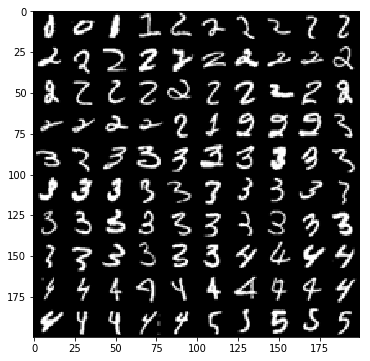

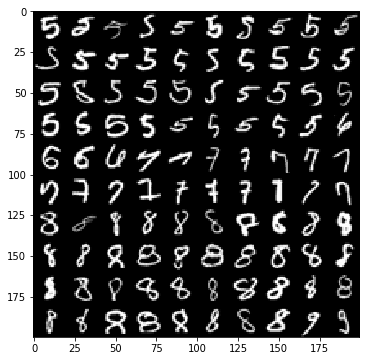

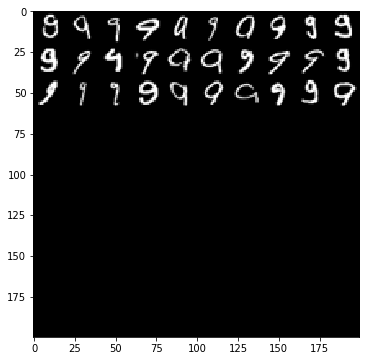

In [44]:
# 显示预测出错的数字
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

## 2. 神经网络
在本练习的前一部分中，你实现了多类逻辑回归以识别手写数字。 然而，逻辑回归不能形成更复杂的假设，因为它只是一个线性分类器。  
在本练习的这一部分中，你将使用与以前相同的训练集来实现神经网络来识别手写数字。 神经网络将能够表示形成非线性假设的复杂模型。   
本周，你将使用我们已经训练过的神经网络参数。 你的目标是实现前馈传播算法以使用我们的权重进行预测。   
在下周的练习中，您将编写用于学习神经网络参数的反向传播算法。
### 2.1 模型表示
我们的神经网络如Figure 2所示。它有3层 - 输入层，隐藏层和输出层。 回想一下，我们的输入是数字图像的像素值。 由于图像大小为20×20，因此我们得到400个输入层单元（不包括总是输出+1的额外偏置单元）。 和以前一样，训练数据将被加载到变量X和y中。 
<img src="docimg/fig2.png">
<center>Figure2 神经网络模型</center>
你已经获得了我们已经培训过的一组网络参数(Θ(1),Θ(2))。 它们存储在ex3weights.mat中，并由ex3 nn.m加载到Theta1和Theta2中。参数的大小适合神经网络，第二层有25个单元，10个输出单元（对应10个数字类）。